<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/CovidMaskClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution neural network Covid-19 Mask Classifier

Link utili dove poter scaricare datasets
* [Kaggle](https://www.kaggle.com/datasets?fileType=csv)
* [Google dataset](https://www.kaggle.com/datasets?fileType=csv)
* [Covid-19 Mask Dataset Github](https://github.com/visiont3lab/covid-mask-classifier.git)
* [Medical MNSIT]([Kaggle](https://www.kaggle.com/andrewmvd/medical-mnist))
* [Pytorch Cifar 10 dataset Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
* [Paper with code Image classification Cifar dataset](https://paperswithcode.com/sota/image-classification-on-cifar-10)
* [AdaptiveAvgPool2d](https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d)
* [AlexNet Pytorch](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)

Useful bash commands

```
!rm -rf images
!mkdir -p images
!zip -r images.zip images
```




## Import Library

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import cv2
import torch.nn as nn
import os
from PIL import Image
from datetime import datetime
import pandas as pd
import cv2
import numpy as np
import shutil
import random
from torchsummary import summary
import copy
import plotly.graph_objects as go

## Download Dataset Covid Mask Classifier


In [2]:
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

fatal: destination path 'covid-mask-classifier' already exists and is not an empty directory.


### Option 1) Data Loader from memory

In [3]:
# Generate Train test folder by using scikit learn train test split
folder_path = os.path.join("covid-mask-classifier","dataset")
classes = {'mask': 0, 'no-mask': 1}
## -----------  Read Data
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 256
X = []
Y = []
for i in range(0,num_classes):
    fpath = os.path.join(folder_path, class_name[i])
    for name in os.listdir(fpath):
        path_read_im = os.path.join(fpath, name)
        im = np.array( Image.open(path_read_im).convert('RGB').resize((size,size)) )
        X.append(im)
        Y.append(i)
X = np.array(X, dtype="float32").transpose(0,3,1,2)
Y = np.array(Y, dtype="float32")
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,shuffle=True,random_state=2)
print(f"X Train shape: {X_train.shape} , X Test shape: {X_test.shape}")

X Train shape: (699, 3, 256, 256) , X Test shape: (300, 3, 256, 256)


tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 0])


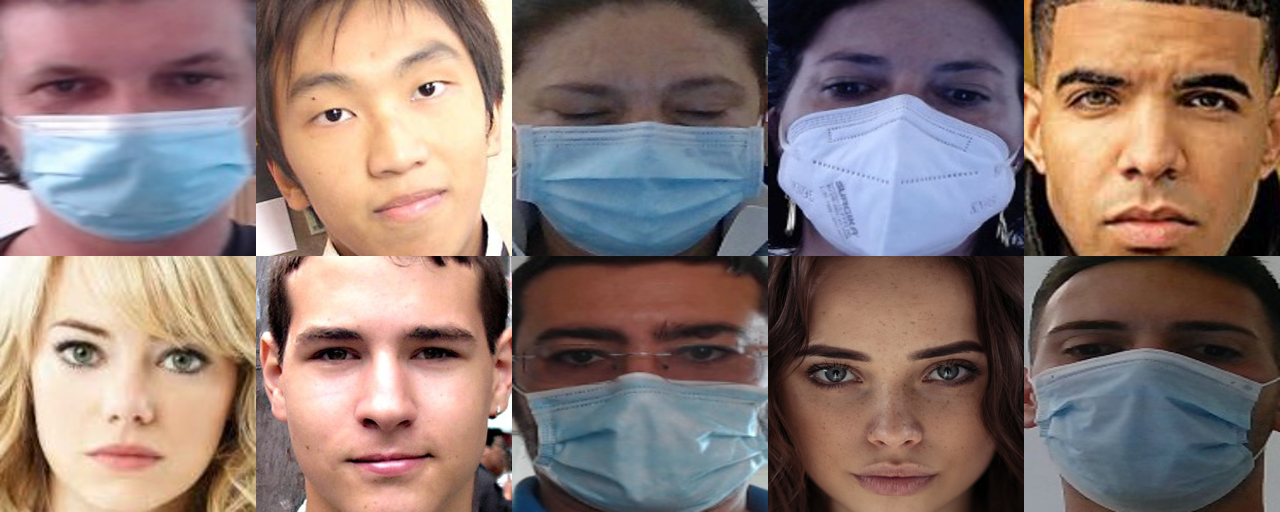

In [4]:
# generate image dataset
class ImageDataset(Dataset):
    def __init__(self, x,y):
        self.x = torch.from_numpy(x).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.LongTensor).reshape(-1)
    def __getitem__(self, index):
        x = self.x[index]/255
        y = self.y[index]
        return x, y
    def __len__(self):
        return self.x.shape[0]

train_ds = ImageDataset(X_train,Y_train)
test_ds = ImageDataset(X_test,Y_test)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=10,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=10,shuffle=True)

for x,y in test_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=0)
    im = transforms.ToPILImage()(batch_grid)
    display(im)
    break

### Option 2) Data Loader from Filepaths

In [5]:
# We want to start in this case from two folder train and test
# for this example we will create train and test folder
# randomly by using this script
# Random create train and test folders
folder_path = os.path.join("covid-mask-classifier","dataset")
folder_train_path = os.path.join("covid-mask-classifier","dataset","train")
folder_test_path = os.path.join("covid-mask-classifier","dataset","test")
classes = {'mask': 0, 'no-mask': 1}
class_name =  list(classes.keys())
filepaths_train = []
filepaths_test = []
num_test_images = 100

# Create train and test directory
for c in classes.keys():
    try:
        os.makedirs(os.path.join(folder_train_path,c))
    except Exception as e:
        print(e)
    try:
        os.makedirs(os.path.join(folder_test_path,c))
    except Exception as e:
        print(e)

# Get train and test filepaths
for c in classes.keys():
    p = os.path.join(folder_path, c)
    filepaths = os.listdir(p)
    filepaths = [os.path.join(p,filepath) for filepath in filepaths]
    test = random.sample(filepaths, num_test_images)
    train = [x for x in filepaths if x not in test]
    filepaths_train.extend(train)
    filepaths_test.extend(test)
    
# Copy images inside train folder
for f in filepaths_train:
    last = "/".join(f.split("/")[-2:])
    path = os.path.join(folder_train_path,last)
    shutil.copy(f,path)

# Copy images inside test folder
for f in filepaths_test:
    last = "/".join(f.split("/")[-2:])
    path = os.path.join(folder_test_path,last)
    shutil.copy(f,path)

[Errno 17] File exists: 'covid-mask-classifier/dataset/train/mask'
[Errno 17] File exists: 'covid-mask-classifier/dataset/test/mask'
[Errno 17] File exists: 'covid-mask-classifier/dataset/train/no-mask'
[Errno 17] File exists: 'covid-mask-classifier/dataset/test/no-mask'


tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1])


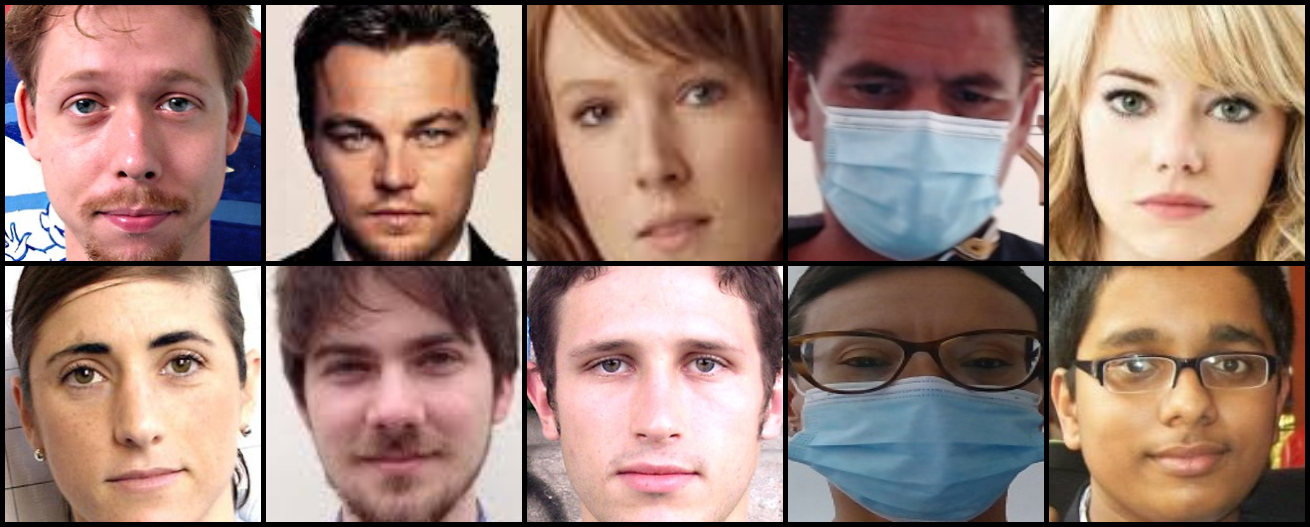

In [6]:
# Generate Train test folder
folder_train_path = os.path.join("covid-mask-classifier","dataset","train")
folder_test_path = os.path.join("covid-mask-classifier","dataset","test")
classes = {'mask': 0, 'no-mask': 1}
## -----------  Read Data
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 256 # training size

train_transform = transforms.Compose([                                    
                                    #transforms.ToPILImage(),  # Tensor of Numpy array to Pillow
                                    transforms.Resize((size,size)),
                                    #transforms.RandomApply([
                                    #    transforms.ColorJitter(brightness=0.5,contrast=0.3),
                                    #], p=0.5),
                                    #transforms.RandomApply([
                                    #    transforms.RandomAffine(degrees=3)
                                    #], p=0.5),
                                    #transforms.RandomHorizontalFlip(p=0.5), # Pillow transformation
                                    transforms.ToTensor()          # Pillow to tensor [0-1]
                            ])   
test_transform = transforms.Compose([      
                                    transforms.Resize((size,size)),                              
                                    transforms.ToTensor()          # Pillow to tensor [0-1]
                            ])  

class ImageDataset(Dataset):
    def __init__(self, folder_path,classes,transform=None):
        names = os.listdir(folder_path) 
        self.filepaths = []
        self.y = []
        for c in classes.keys():
            folder_class = os.path.join(folder_path,c)
            names = os.listdir(folder_class)
            f = [os.path.join(folder_path,c,name) for name in names]
            self.filepaths.extend(f)
            self.y.extend([classes[c] for i in range(0,len(f))])
        self.transform = transform
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        y = self.y[index]
        x = Image.open(filepath).convert("RGB")
        #m = np.array(x)
        #print(m)
        if self.transform:
            x =self.transform(x)
        return x,y
    def __len__(self):
        return len(self.filepaths)

train_ds = ImageDataset(folder_train_path,classes,train_transform)
test_ds = ImageDataset(folder_test_path,classes,test_transform)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=10,shuffle=True)
for x,y in train_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=5)
    im = transforms.ToPILImage()(batch_grid)
    display(im)
    break

## Deep Learning Network Design (AlexNet)

In [7]:
class AlexNet(nn.Module):

    def __init__(self,num_classes):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        # Visualization purpose
        self.visualize = []

    def forward(self, x):
        self.visualize = []

        # Estrattore di feature
        self.visualize.append(x)

        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        self.visualize.append(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        self.visualize.append(x)

        x = torch.relu(self.conv3(x))
        self.visualize.append(x)

        x = torch.relu(self.conv4(x))
        self.visualize.append(x)

        x = torch.relu(self.conv5(x))
        x = self.pool3(x)
        self.visualize.append(x)

        x = self.avgpool(x)
        self.visualize.append(x)

        # Classificatore
        x = self.drop1(x)
        x = x.reshape(-1,256*6*6)
        x = torch.relu( self.fc1(x) )
        x = self.drop2(x)
        x = self.fc3(x)   

        # Log softmax
        x = torch.log_softmax(x,dim=-1)
        return x

    def plot(self):
        try:
            shutil.rmtree("images")
        except:
            pass
        try:
            os.makedirs("images")
        except:
            pass
        for x in self.visualize:
            #print(x.shape)
            xx = x[0].unsqueeze(1)
            batch_grid =torchvision.utils.make_grid(xx, nrow=20, padding=5,keep_channels=True).permute(1, 2, 0)
            #print(batch_grid.shape)
            im = batch_grid.numpy()*255
            r = datetime.now().strftime("%H-%M-%S-%f")
            im = cv2.resize(im, (1280,720))
            cv2.imwrite("images/image_"+r+".png", im)


In [8]:
# Test Created net
x,y = next(iter(train_dl))
net = AlexNet(num_classes)

# Print model summary
summary(net,input_size=(3,256,256),batch_size=-1,device="cpu")

# Output 
out = net.forward(x)
net.plot()
print(out)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
         MaxPool2d-2           [-1, 64, 31, 31]               0
            Conv2d-3          [-1, 192, 31, 31]         307,392
         MaxPool2d-4          [-1, 192, 15, 15]               0
            Conv2d-5          [-1, 384, 15, 15]         663,936
            Conv2d-6          [-1, 256, 15, 15]         884,992
            Conv2d-7          [-1, 256, 15, 15]         590,080
         MaxPool2d-8            [-1, 256, 7, 7]               0
 AdaptiveAvgPool2d-9            [-1, 256, 6, 6]               0
          Dropout-10            [-1, 256, 6, 6]               0
           Linear-11                 [-1, 4096]      37,752,832
          Dropout-12                 [-1, 4096]               0
           Linear-13                    [-1, 2]           8,194
Total params: 40,230,722
Trainable para

## Training

In [9]:
# validation: metric regression
def metrics_func_regression(target, output):
    # Comptue mean squaer error (Migliora quanto piu' ci avviciniamo a zero)
    mse = torch.sum((output - target) ** 2)
    return mse

# validation metric classification
def metrics_func_classification(target, output):
    # Compute number of correct prediction
    pred = output.argmax(dim=-1,keepdim=True)
    corrects =pred.eq(target.reshape(pred.shape)).sum().item()
    return -corrects # minus for coeherence with best result is the most negative one

# training: loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric 
    with torch.no_grad():
        metric_b = metric_func(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b

# one epoch training
def loss_epoch(model, loss_func,metric_func, dataset_dl, sanity_check,opt, device):
    loss = 0.0
    metric = 0.0
    len_data = float(len(dataset_dl.dataset))
    # get batch data
    for xb,yb in dataset_dl:    
        # send to cuda the data (batch size)
        xb = xb.to(device)
        yb = yb.to(device)
        # obtain model output 
        yb_h = model.forward(xb)
        # loss and metric Calculation
        loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
        # update loss
        loss += loss_b
        # update metric
        if metric_b is not None:
            metric+=metric_b 
        if sanity_check is True:
            break
    # average loss
    loss /=len_data
    # average metric
    metric /=len_data
    return loss, metric

# get learning rate from optimizer
def get_lr(opt):
    # opt.param_groups[0]['lr']
    for param_group in opt.param_groups:
        return param_group["lr"]

# trainig - test loop
def train_test(params):
    # --> extract params
    model = params["model"]
    loss_func=params["loss_func"]
    metric_func=params["metric_func"]
    num_epochs=params["num_epochs"]
    opt=params["optimizer"]
    lr_scheduler=params["lr_scheduler"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    device=params["device"]
    continue_training=params["continue_training"]
    sanity_check=params["sanity_check"]
    path2weigths=params["path2weigths"]
    # --> send model to device and print device
    model = model.to(device)
    print("--> training device %s" % (device))
    # --> if continue_training=True load path2weigths
    if continue_training==True and os.path.isfile(path2weigths):
        print("--> continue training  from last best weights")
        weights = torch.load(path2weigths)
        model.load_state_dict(weights)
    # --> history of loss values in each epoch
    loss_history={"train": [],"test":[]}
    # --> history of metric values in each epoch
    metric_history={"train": [],"test":[]}
    # --> a deep copy of weights for the best performing model
    best_model_weights = copy.deepcopy(model.state_dict())
    # --> initialiaze best loss to large value
    best_loss=float("inf")
    # --> main loop
    for epoch in range(num_epochs):
        # --> get learning rate
        lr = get_lr(opt)
        print("----\nEpoch %s/%s, lr=%.6f" % (epoch+1,num_epochs,lr))
        # --> train model on training dataset
        # we tell to the model to enter in train state. it is important because
        # there are somelayers like dropout, batchnorm that behaves 
        # differently between train and test
        model.train()
        train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl,sanity_check, opt,device)
        # --> collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # --> tell the model to be in test (validation) mode
        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, metric_func, test_dl,sanity_check,opt=None,device=device)
        # --> collect loss and metric for test dataset
        loss_history["test"].append(test_loss)
        metric_history["test"].append(test_metric)
        # --> store best model
        if test_loss < best_loss:
            print("--> model improved! --> saved to %s" %(path2weigths))
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            # --> store weights into local file
            torch.save(model.state_dict(),path2weigths)
        # --> learning rate scheduler
        lr_scheduler.step()
        print("--> train_loss: %.6f, test_loss: %.6f, train_metric: %.3f, test_metric: %.3f" % (train_loss,test_loss,train_metric,test_metric))
    # --> load best weights
    model.load_state_dict(best_model_weights)
    return model, loss_history,metric_history
        

In [10]:
# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
model = AlexNet(len(classes.keys()))
opt = optim.Adam(model.parameters(),lr=0.0001)
train_dl = DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=1)
test_dl = DataLoader(test_ds,batch_size=64,shuffle=True,num_workers=1)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999)  #  lr = lr * gamma ** last_epoch
params = {
    "model":                 model,
    "loss_func":             nn.NLLLoss(reduction="sum"), 
    "metric_func":           metrics_func_classification,
    "num_epochs":            20,
    "optimizer":             opt,
    "lr_scheduler":          lr_scheduler,
    "train_dl":              train_dl,
    "test_dl":               test_dl,
    "device":                device,  
    "continue_training" :    True,  # continue training from last save weights
    "sanity_check":          False, # if true we only do one batch per epoch
    "path2weigths":          "./best_model.pt"  
} 
model, loss_history,metric_history = train_test(params)

--> training device cuda:0
--> continue training  from last best weights
----
Epoch 1/20, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.106984, test_loss: 0.065699, train_metric: -0.974, test_metric: -0.984
----
Epoch 2/20, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.070365, test_loss: 0.050853, train_metric: -0.977, test_metric: -0.988
----
Epoch 3/20, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.049989, test_loss: 0.044909, train_metric: -0.987, test_metric: -0.985
----
Epoch 4/20, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.038477, test_loss: 0.039561, train_metric: -0.990, test_metric: -0.989
----
Epoch 5/20, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.034768, test_loss: 0.034303, train_metric: -0.994, test_metric: -0.993
----
Epoch 6/20, lr=0.000100
--> model improved! --> saved to ./best_model.pt
--> train_loss

In [19]:
fig_loss = go.Figure()
fig_metric = go.Figure()

x = [i+1 for i in range(params["num_epochs"])]

fig_loss.add_traces( go.Scatter(x=x,y=loss_history["train"], name="train loss", mode="lines+markers" ) )
fig_loss.add_traces( go.Scatter(x=x,y=loss_history["test"], name="test loss"  , mode="lines+markers") )
fig_loss.update_layout(title="Loss Results", xaxis_title="epochs", hovermode="x")
fig_loss.show()

fig_metric.add_traces( go.Scatter(x=x,y=metric_history["train"], name="train metric", mode="lines+markers") )
fig_metric.add_traces( go.Scatter(x=x,y=metric_history["test"], name="test_metric" , mode="lines+markers") )
fig_metric.update_layout(title="Metric Results", xaxis_title="epochs", hovermode="x")
fig_metric.show()

## Test trained model and visualization convolution filter

### Check Confusion matrix test set

In [12]:
# Load Classification
device = torch.device("cpu")
classes = {'mask':0, 'no-mask':1}
net = AlexNet(len(classes)).to(device)
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)

# Tell the model layer that we are going to use the model in evaluation  mode!
net.eval()

# Predict Classication
with torch.no_grad():
    for x,y in test_dl:
        y_hat = net.forward(x).argmax(dim=-1,keepdim=True).numpy().reshape(-1)

        # Visualize results
        cm = confusion_matrix(y,y_hat)
        names_pred = [ "Pred: " + n for n in classes]
        df = pd.DataFrame(cm, columns=names_pred, index=classes)
        display(df)

Pred: mask  Pred: no-mask
mask             28              0
no-mask           0             36

Pred: mask  Pred: no-mask
mask             30              0
no-mask           0             34

Pred: mask  Pred: no-mask
mask             32              0
no-mask           0             32

Pred: mask  Pred: no-mask
mask             34              0
no-mask           0             30

Pred: mask  Pred: no-mask
mask             32              0
no-mask           0             32

Pred: mask  Pred: no-mask
mask             30              1
no-mask           0             33

Pred: mask  Pred: no-mask
mask             34              0
no-mask           0             30

Pred: mask  Pred: no-mask
mask             29              0
no-mask           0             35

Pred: mask  Pred: no-mask
mask             36              0
no-mask           0             28

Pred: mask  Pred: no-mask
mask             30              0
no-mask           0             34

Pred: mask  Pred: no-mask
mask             32              0
no-mask           0             32

Pred: mask  Pred: no-mask
mask             17              0
no-mask           0             13

### Test and visualize one single image

mask


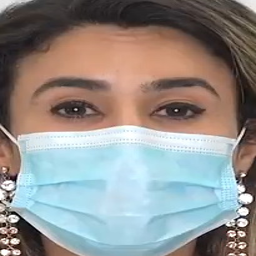

mask


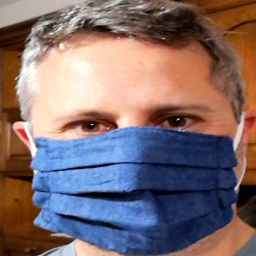

In [13]:
# Read Image
def preprocess_image(filepath,size=256):
    #filepath = os.path.join("covid-mask-classifier","dataset","mask","5e7cded7ba85ee690669c204.jpg")
    im_pil = Image.open(filepath).convert("RGB").resize((256,256))
    im_tensor = transforms.ToTensor()( im_pil ).unsqueeze(0)
    return im_tensor, im_pil

# Load Model
device = torch.device("cpu")
classes = {'mask':0, 'no-mask':1}
class_name =  list(classes.keys())
net = AlexNet(len(classes)).to(device)
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)
size  = 256 # Training size shape

# Tell the model layer that we are going to use the model in evaluation  mode!
net.eval()

# Predict
folder_path = os.path.join("covid-mask-classifier","dataset","mask")
#folder_path = os.path.join("covid-mask-classifier","dataset","no-mask")
names = os.listdir(folder_path)
filepaths = [os.path.join(folder_path,name) for name in names]
for filepath in filepaths[3:5]:  # Show only 5 images
    im_tensor, im_pil = preprocess_image(filepath,size)
    with torch.no_grad():
        out = net.forward(im_tensor).argmax(dim=-1,keepdim=True).item()
    print(class_name[out])
    display( im_pil )

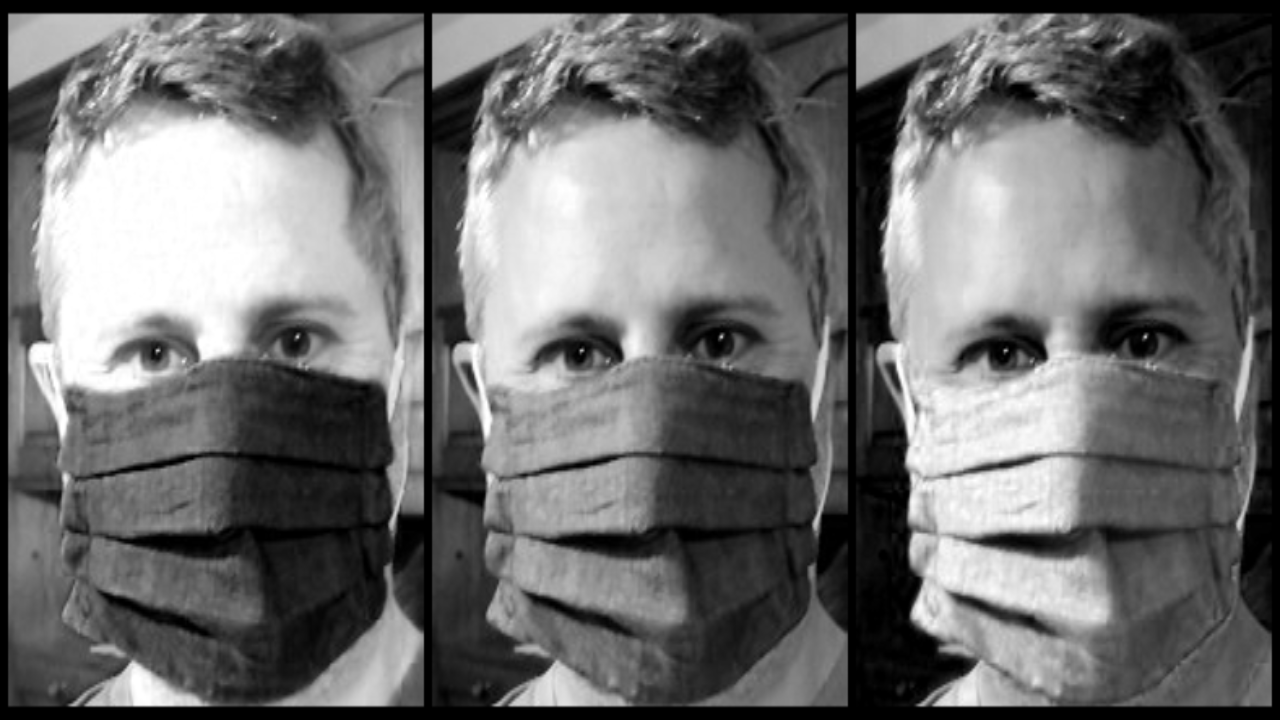

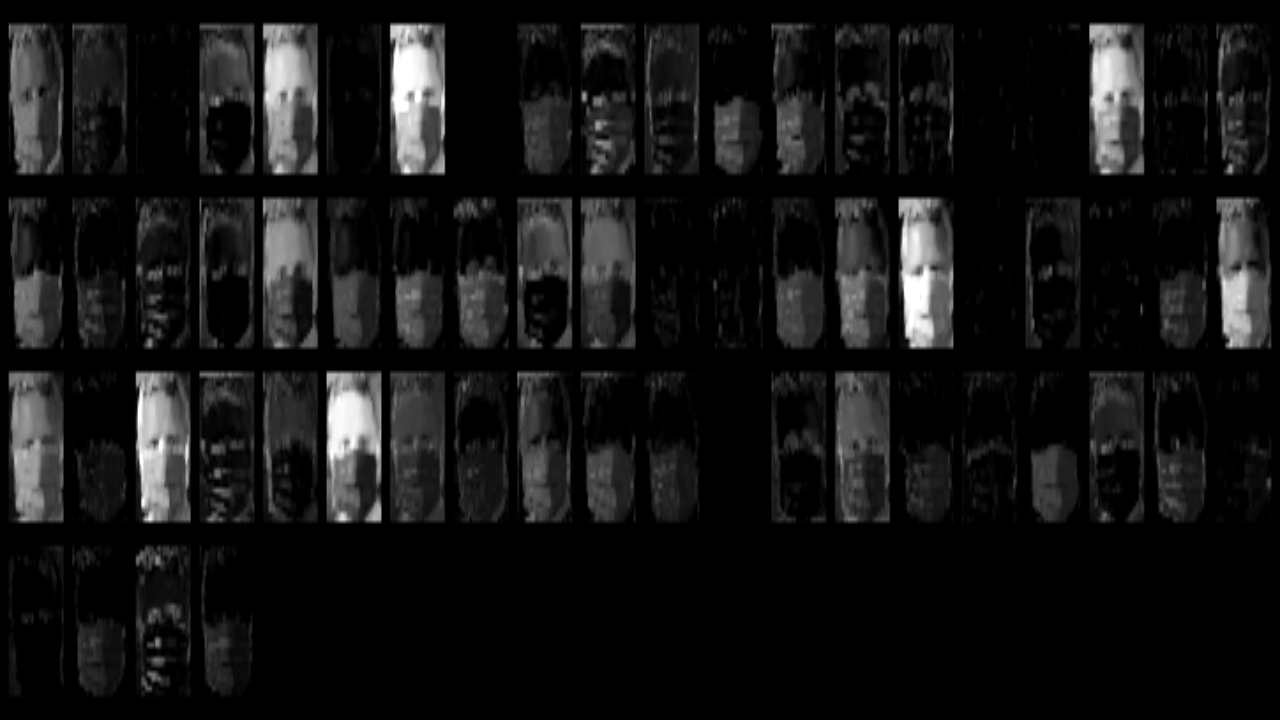

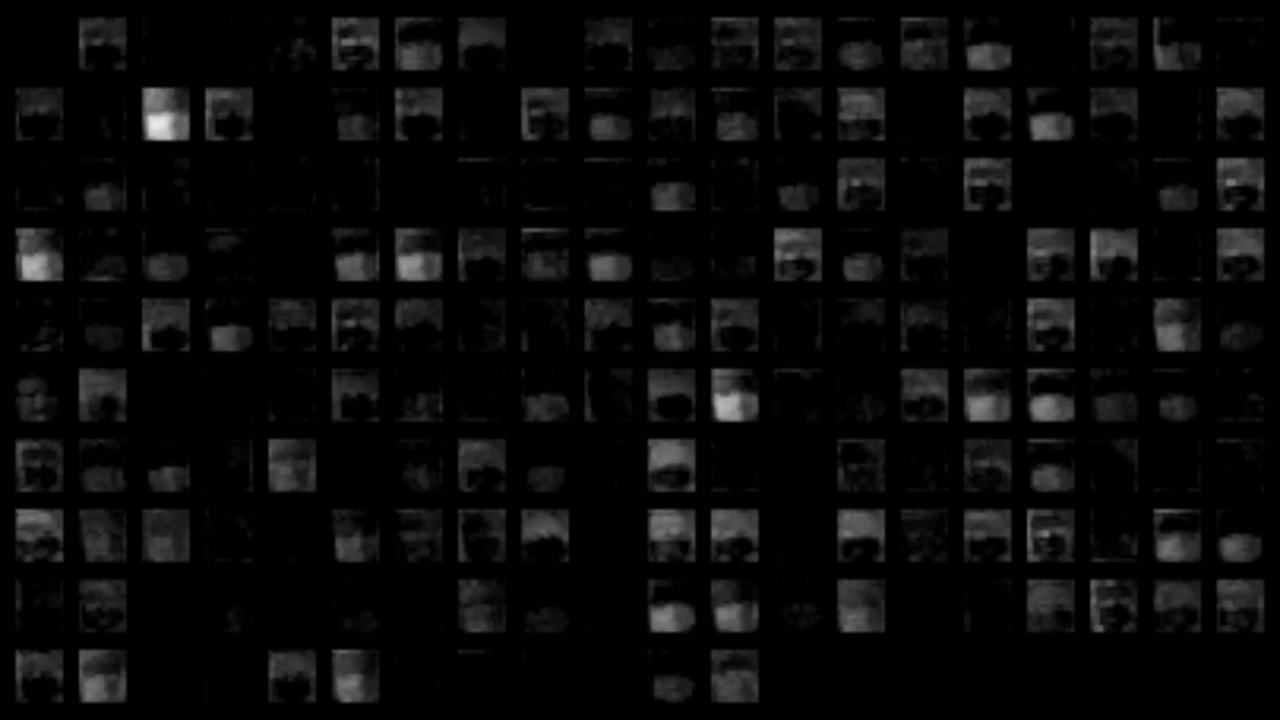

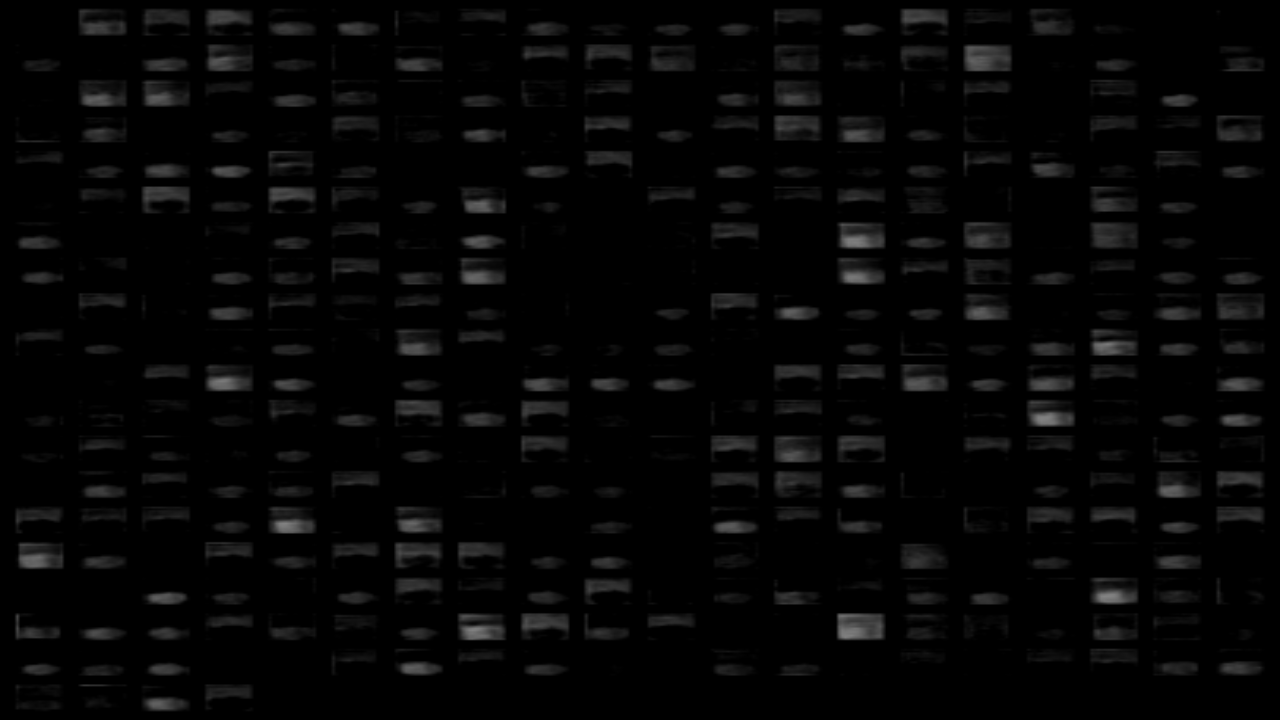

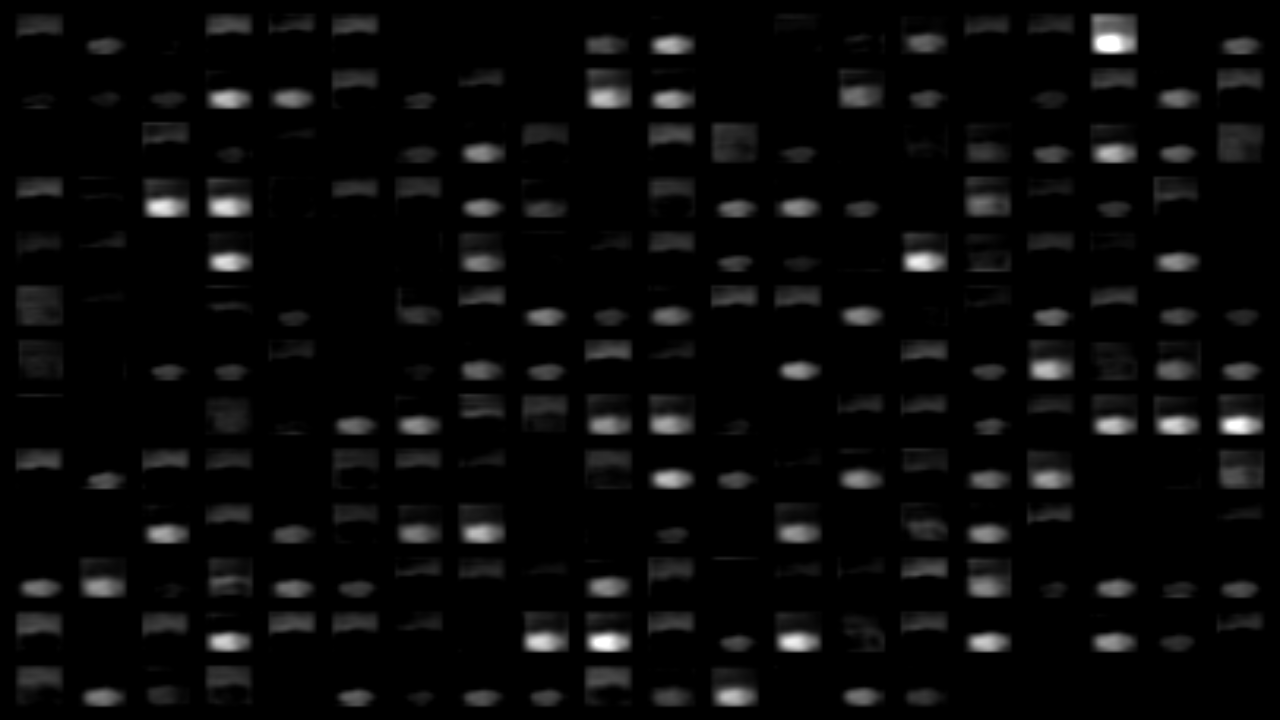

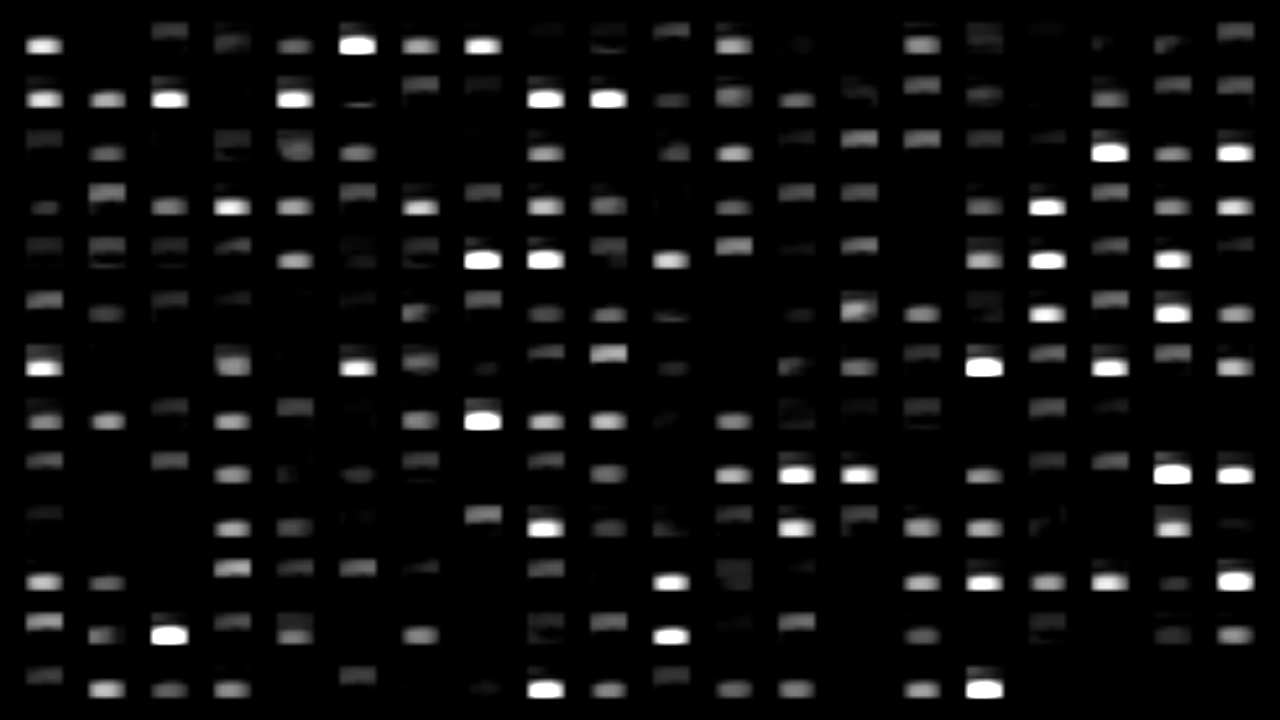

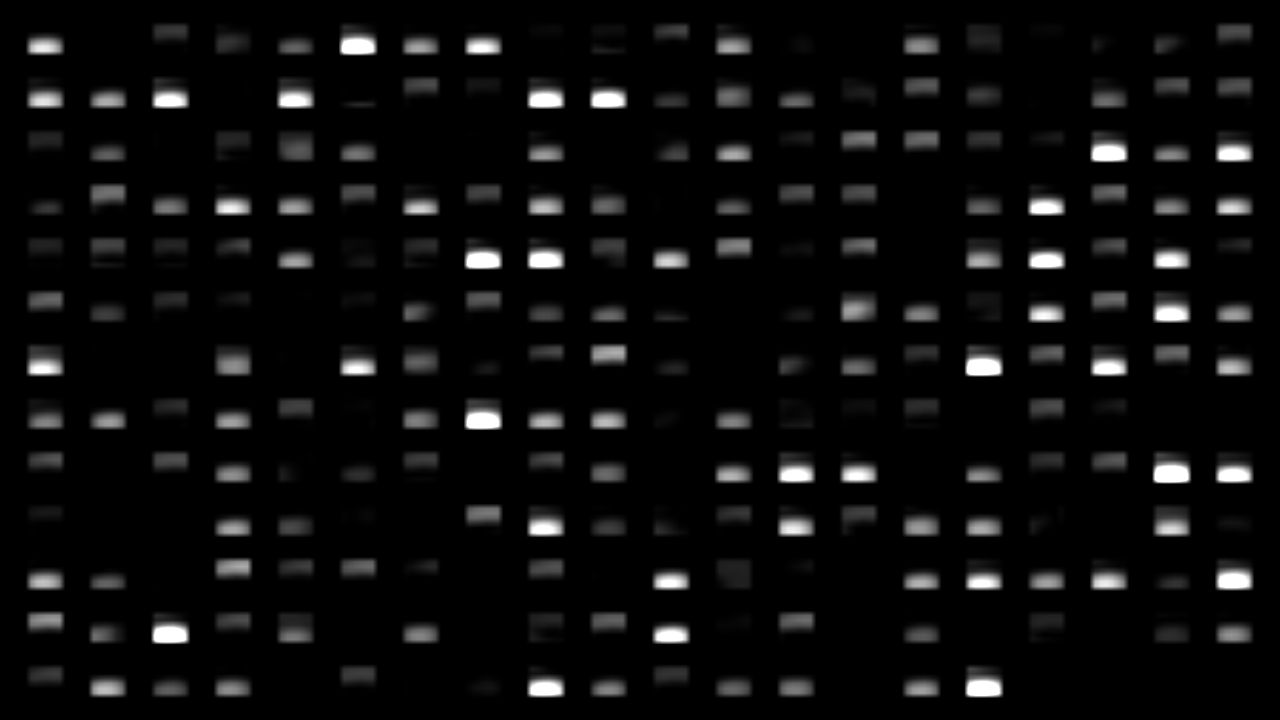

In [14]:
# Display filters
# Visualize filter of last image processsed (Look inside images folder)
net.plot()
for name in sorted(os.listdir("images")):
    path = "images/"+name
    display(Image.open(path))